In [4]:
import numpy as np
import pandas as pd
import glob
import os
import xlrd
import openpyxl
import pickle
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [6]:
# load dataframes from pickle file
with open('../data/data_clean.pkl', 'rb') as f:
    saved = pickle.load(f)
    price_df = saved['price_df']
    return_df = saved['return_df']
    category_map = saved['category_mapping']

In [ ]:
# machine learning
from scipy.stats import multivariate_normal
from sklearn import cluster, datasets, mixture
from sklearn.mixture import GaussianMixture

def standardize(x_series):
    mean_x = np.mean(x_series)
    std_x = np.std(x_series)
    x_std = np.array((x_series - mean_x) / std_x)
    return x_std

In [ ]:
# Use permutation to break the autocorrelation
seq = np.random.permutation(return_df.shape[0])
sorted_returns = return_df.reset_index().iloc[seq]

# Standardize returns
returns_std = sorted_returns.iloc[:,1:].apply(standardize)
returns_std = np.array(returns_std)

### Start with 1-D GMM

In [ ]:
X1 = standardize(sorted_returns["equity"])
X1 = np.array(X1).reshape(-1, 1)

# bins = np.linspace(np.min(X1), np.max(X1), 100)
# plt.figure(figsize=(10,7))
# plt.scatter(X1, [0.005] * len(X1), color='navy', s=20, marker=2, label='train data')

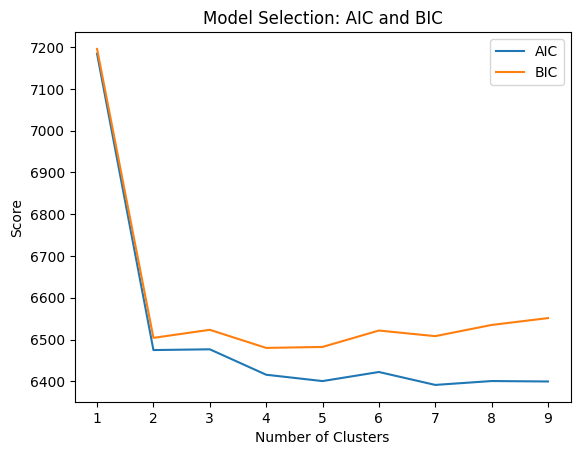

In [52]:
aic_vals = []
bic_vals = []
ks = range(1, 10)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X1.reshape(-1, 1))
    aic_vals.append(gmm.aic(X1.reshape(-1, 1)))
    bic_vals.append(gmm.bic(X1.reshape(-1, 1)))

plt.plot(ks, aic_vals, label='AIC')
plt.plot(ks, bic_vals, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('Model Selection: AIC and BIC')
plt.show()

In [53]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X1.reshape(-1, 1))

# Extract estimated parameters
means = gmm.means_.flatten()             
variances = gmm.covariances_.flatten()    
weights = gmm.weights_                   
print("Means:", means)
print("Variances:", variances)
print("Weights:", weights)

Means: [ 0.06355728 -0.24261711]
Variances: [0.34824169 3.41367785]
Weights: [0.79241478 0.20758522]


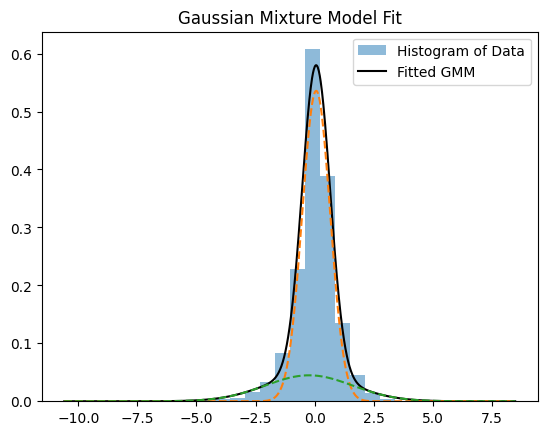

In [54]:
from scipy.stats import norm

x_vals = np.linspace(min(X1), max(X1), 1000)
pdf = sum(w * norm.pdf(x_vals, m, np.sqrt(v)) 
          for w, m, v in zip(weights, means, variances))

plt.hist(X1, bins=30, density=True, alpha=0.5, label='Histogram of Data')
plt.plot(x_vals, pdf, label='Fitted GMM', color='black')

# Plot each component
for w, m, v in zip(weights, means, variances):
    plt.plot(x_vals, w * norm.pdf(x_vals, m, np.sqrt(v)), linestyle='--')

plt.legend()
plt.title("Gaussian Mixture Model Fit")
plt.show()

### Move to 2-Dimension

In [59]:
X2 = standardize(sorted_returns["us_dollar"])
X2 = np.array(X2).reshape(-1, 1)
X = np.concatenate((X1, X2), axis=1)

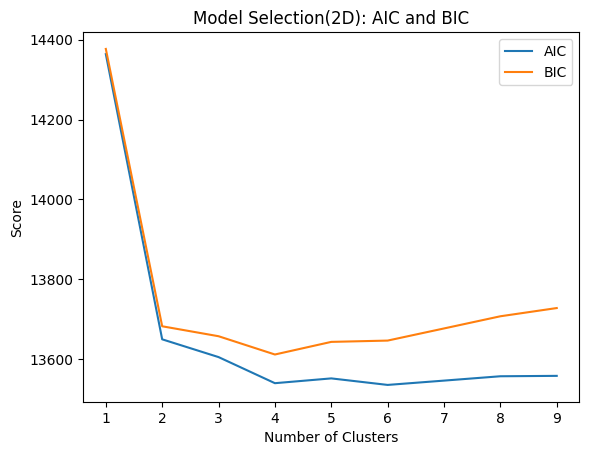

In [61]:
aic_vals = []
bic_vals = []
ks = range(1, 10)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X.reshape(-1, 1))
    aic_vals.append(gmm.aic(X.reshape(-1, 1)))
    bic_vals.append(gmm.bic(X.reshape(-1, 1)))

plt.plot(ks, aic_vals, label='AIC')
plt.plot(ks, bic_vals, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('Model Selection(2D): AIC and BIC')
plt.show()

In [ ]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X.reshape(-1, 1))

# Extract estimated parameters
means = gmm.means_.flatten()             
variances = gmm.covariances_.flatten()    
weights = gmm.weights_                   
print("Means:", means)
print("Variances:", variances)
print("Weights:", weights)

# x_vals = np.linspace(min(X), max(X), 1000)
# pdf = sum(w * norm.pdf(x_vals, m, np.sqrt(v)) 
#           for w, m, v in zip(weights, means, variances))

# plt.hist(X, bins=30, density=True, alpha=0.5, label='Histogram of Data')
# plt.plot(x_vals, pdf, label='Fitted GMM', color='black')

# # Plot each component
# for w, m, v in zip(weights, means, variances):
#     plt.plot(x_vals, w * norm.pdf(x_vals, m, np.sqrt(v)), linestyle='--')

# plt.legend()
# plt.title("Gaussian Mixture Model Fit")
# plt.show()

Means: [ 0.05910699 -0.11083755]
Variances: [0.3622422 2.1770913]
Weights: [0.65219834 0.34780166]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### 16-Dimension GMM

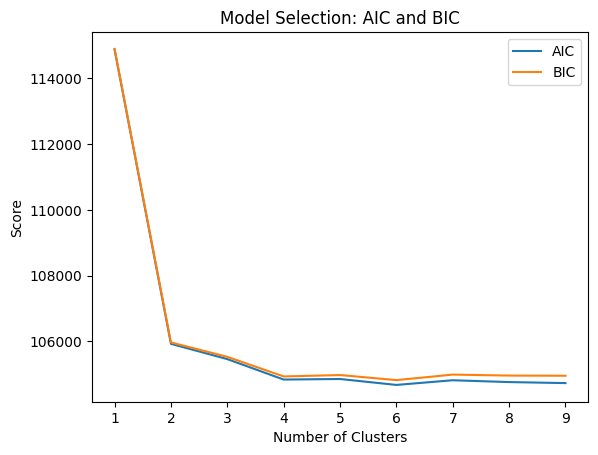

In [85]:
aic_vals = []
bic_vals = []
ks = range(1, 10)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(returns_std.reshape(-1, 1))
    aic_vals.append(gmm.aic(returns_std.reshape(-1, 1)))
    bic_vals.append(gmm.bic(returns_std.reshape(-1, 1)))

plt.plot(ks, aic_vals, label='AIC')
plt.plot(ks, bic_vals, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('Model Selection: AIC and BIC')
plt.show()

In [91]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(returns_std)

# Extract estimated parameters
means = gmm.means_.flatten()             
variances = gmm.covariances_.flatten()    
weights = gmm.weights_                   
print("Means:", means)
print("Variances:", variances)
print("Weights:", weights)

Means: [-8.99501663e-02 -6.98182383e-01 -5.06079145e-01 -5.90637357e-01
 -4.77740722e-01 -6.63789881e-01 -7.75594186e-01  3.66406322e-01
  7.06021172e-01 -4.35611674e-01 -5.56718803e-01  6.23429687e-02
 -4.75760029e-01 -7.90206173e-01 -6.65091810e-01 -7.61810283e-01
  3.64839514e-02  4.66339255e-02 -3.55892521e-02 -2.81486494e-02
 -1.54460885e-02 -3.03111788e-02 -1.51559676e-02 -2.40395432e-02
  6.54207952e-02 -4.58622483e-02  3.92481205e-02 -8.45588414e-03
 -3.73247977e-02  4.23823207e-04 -2.73209463e-02  1.99849361e-02
 -6.42804800e-02  2.35722835e-02  3.79450200e-02  8.45295156e-02
  6.22681879e-02  5.06278127e-02  5.85760084e-02 -9.39959513e-02
 -4.66807139e-02 -8.32594554e-04 -2.56197280e-03 -4.79760074e-03
  3.08135755e-02 -8.72228761e-02  3.79671785e-02 -2.18329914e-02
  3.00231297e-03  2.22937916e-02  6.44194038e-02  4.96402344e-02
  3.64907217e-02  7.09918568e-02  6.68379230e-02  1.78811039e-02
 -1.04870512e-01  8.00006135e-02  2.39461883e-02  2.45453834e-03
  6.54575988e-02  